In [237]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime

In [238]:
at200 = pd.read_csv("../data/csv_files/at200.csv")

In [246]:
# preprocess
def preprocess(df, encoder):
    df2 = df.drop(['Level: Elevation (m)'], axis = 1) #dropping this value since there are only 22 no-null entries
    df2 = df2.dropna() # dropping all the rows containing one null values
    print(df2)
    df2['Date Time'] = pd.to_datetime(df2['Date Time'])
    
    df2['year'] = df2['Date Time'].dt.year
    df2['month'] = df2['Date Time'].dt.month
    df2['day'] = df2['Date Time'].dt.day
    df2['hour'] = df2['Date Time'].dt.hour
    df2['minute'] = df2['Date Time'].dt.minute
    df2['second'] = df2['Date Time'].dt.second

    df2 = df2.drop('Date Time', axis = 1)

    #encode station_id
    station_id_encoded = encoder.fit_transform(df2[['station_id']])
    station_id_encoded_df = pd.DataFrame(station_id_encoded, columns=[f'station_id_{i}' for i in range(station_id_encoded.shape[1])])

    #approach 2: Use label encoder
    # label_encoder = LabelEncoder()
    # df2['station_id'] = label_encoder.fit_transform(df2['station_id'])
    
    # Drop the original 'station_id' column and append the one-hot encoded columns
    df2 = df2.drop('station_id', axis=1)
    df2 = pd.concat([df2.reset_index(drop = True), pd.DataFrame(station_id_encoded_df).reset_index(drop = True)], axis = 1)

    # Normalize the numerical features
    scaler = StandardScaler()
    df2[df2.columns] = scaler.fit_transform(df2[df2.columns])

    return df2

In [252]:
onehot_encoder = OneHotEncoder(sparse_output=False)
at200_preprocessed = preprocess(at200, onehot_encoder)
X = at200_preprocessed.values

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

                     Date Time  Actual Conductivity (µS/cm)  \
0      2023-01-11 14:34:00.000                   161.135101   
1      2023-01-11 14:39:00.000                   161.549484   
2      2023-01-12 00:00:00.000                   160.563217   
3      2023-01-13 00:00:00.000                   160.465378   
4      2023-01-14 00:00:00.000                   160.041122   
...                        ...                          ...   
98129  2023-10-31 00:00:00.000                   340.631592   
98130  2023-10-31 01:00:00.000                   340.574677   
98131  2023-10-31 02:00:00.000                   340.628418   
98132  2023-10-31 03:00:00.000                   340.634491   
98133  2023-10-31 04:00:00.000                   340.636108   

       Specific Conductivity (µS/cm)  Salinity (psu)  Resistivity (Ω-cm)  \
0                         169.814270        0.089782         6205.972656   
1                         169.920212        0.089823         6190.053711   
2              

In [268]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 25),  # First hidden layer with 25 neurons
            nn.ReLU(),
            nn.Linear(25, 18),        # Second hidden layer with 18 neurons
            nn.ReLU(),
            nn.Linear(18, 12),         # Third hidden layer with 12 neurons
            nn.ReLU(),
            nn.Linear(12, 8),         # Bottleneck layer with 8 neurons
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 12),         # Mirror of the third hidden layer
            nn.ReLU(),
            nn.Linear(12, 18),         # Mirror of the second hidden layer
            nn.ReLU(),
            nn.Linear(18, 25),        # Mirror of the first hidden layer
            nn.ReLU(),
            nn.Linear(25, input_dim), # Output layer
            nn.Sigmoid()               # to Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [269]:
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [270]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch [1/100], Loss: 0.7829 Validation Loss: 0.6897
Epoch [2/100], Loss: 0.7057 Validation Loss: 0.6882
Epoch [3/100], Loss: 0.7050 Validation Loss: 0.6880
Epoch [4/100], Loss: 0.7049 Validation Loss: 0.6876
Epoch [5/100], Loss: 0.7045 Validation Loss: 0.6871
Epoch [6/100], Loss: 0.7038 Validation Loss: 0.6864
Epoch [7/100], Loss: 0.7034 Validation Loss: 0.6864
Epoch [8/100], Loss: 0.7034 Validation Loss: 0.6861
Epoch [9/100], Loss: 0.7035 Validation Loss: 0.6874
Epoch [10/100], Loss: 0.6846 Validation Loss: 0.6644
Epoch [11/100], Loss: 0.6672 Validation Loss: 0.6466
Epoch [12/100], Loss: 0.6600 Validation Loss: 0.6453
Epoch [13/100], Loss: 0.6596 Validation Loss: 0.6445
Epoch [14/100], Loss: 0.6582 Validation Loss: 0.6434
Epoch [15/100], Loss: 0.6576 Validation Loss: 0.6429
Epoch [16/100], Loss: 0.6574 Validation Loss: 0.6435
Epoch [17/100], Loss: 0.6574 Validation Loss: 0.6428
Epoch [18/100], Loss: 0.6567 Validation Loss: 0.6401
Epoch [19/100], Loss: 0.6546 Validation Loss: 0.6404
Ep

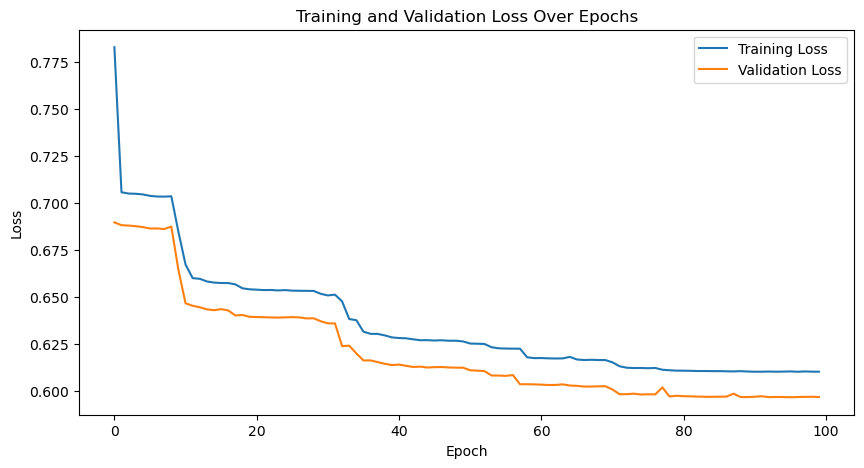

In [271]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [274]:
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.5967


In [273]:
# Function to decode one-hot encoded station_id
def decode_station_id(encoded_data, onehot_encoder):
    decoded_data = onehot_encoder.inverse_transform(encoded_data)
    return decoded_data

# Select a few test samples to demonstrate
num_examples = 5
example_inputs = X_test_tensor[:num_examples]
model.eval()
with torch.no_grad():
    example_outputs = model(example_inputs).numpy()

# # Decode the station_id for the inputs and outputs
# decoded_station_ids_input = decode_station_id(example_inputs.numpy()[:, -station_id_encoded.shape[1]:], onehot_encoder)
# decoded_station_ids_output = decode_station_id(example_outputs[:, -station_id_encoded.shape[1]:], onehot_encoder)

# Print example inputs and outputs
for i in range(num_examples):
    print(f"Example {i+1}")
    print("Original Input:")
    print(example_inputs[i].numpy())
    print("Reconstructed Output:")
    print(example_outputs[i])
    # print("Original Station ID (decoded):", decoded_station_ids_input[i])
    # print("Reconstructed Station ID (decoded):", decoded_station_ids_output[i])
    print()


Example 1
Original Input:
[ 1.1796578   1.1233625   1.185421   -0.98185384  1.1236838   1.1233624
 -0.4638389   0.55381787 -1.7504987  -1.1430181  -1.1444681  -1.151843
 -0.7417955   0.61970395  1.7521781   1.7557887  -0.5645649  -0.26539183
 -0.6754494   0.42849877  0.28563815  1.4683641  -0.63026565 -0.04618563
  0.          2.078457   -0.19411695 -0.31674236 -0.52835387 -0.34099814
 -0.34104475 -0.2936573  -0.46622488]
Reconstructed Output:
[9.9994993e-01 9.9988997e-01 9.9994469e-01 1.1332690e-12 9.9867392e-01
 9.9989653e-01 1.2672550e-06 5.3699237e-01 7.2660778e-35 5.5546340e-14
 1.4428938e-13 1.3484311e-13 0.0000000e+00 7.9484773e-01 9.9944812e-01
 9.9941754e-01 7.9972300e-20 1.7093558e-06 9.4561802e-25 4.3343875e-01
 2.0309399e-10 9.9942231e-01 1.0573253e-03 0.0000000e+00 1.1647073e-07
 9.9997985e-01 6.9356057e-15 5.1980554e-23 0.0000000e+00 1.7977679e-06
 2.7450261e-26 2.3090916e-20 0.0000000e+00]

Example 2
Original Input:
[-0.7312072  -0.7305335  -0.731471    0.34507266 -0.475